<a href="https://colab.research.google.com/github/george-zakharov/ml_notebooks/blob/master/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Homework 3

#### Light: 
выполнить предобработку признаков данного датасета как числовых, так и категориальных. Далее выполнить нормировку признаков с помощью библиотеки scikit learn (StandartScalar) и обучить известные Вам модели бинарной классификации (kNN, Bayes, SVM).

#### Pro: 
выполнить задание Light + проверить распределение признаков на близость к нормальному. Трансформировать признаки, распределение которых далеко от нормального. Сравнить результаты моделей бинарной классификации до и после трансформации признаков.


### Homework 5
#### Light:
добавить в блокнот решения Homework 3 построение моделя RandomForest;

воспользоваться одним из способов работы с разбалансированным датасетом Churn.

#### Pro:
добавить в блокнот решения Homework 3 построение моделя RandomForest;

использовать все способы работы с разбалансированным датасетом Churn.

# Load libs

In [0]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import PowerTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn import svm

from sklearn.preprocessing import StandardScaler

from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import shapiro
from scipy.stats import normaltest
import matplotlib.pyplot as plt

# Load Google Disk

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


https://www.kaggle.com/becksddf/churn-in-telecoms-dataset

# Read dataset, analysis

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML/3/Homework/telecom_churn.csv')

In [0]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


По умолчанию `Pandas` выводит всего 20 столбцов и 60 строк. Можно использовать функцию `set_option`:

In [0]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

Регулируем количество знаков после запятой:

In [0]:
pd.set_option('precision', 2)

**Посмотрим на размер данных, названия признаков и их типы**

In [0]:
print(df.shape)

(3333, 20)


In [0]:
print(df.columns)

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')


In [0]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
State                     3333 non-null object
Account length            3333 non-null int64
Area code                 3333 non-null int64
International plan        3333 non-null object
Voice mail plan           3333 non-null object
Number vmail messages     3333 non-null int64
Total day minutes         3333 non-null float64
Total day calls           3333 non-null int64
Total day charge          3333 non-null float64
Total eve minutes         3333 non-null float64
Total eve calls           3333 non-null int64
Total eve charge          3333 non-null float64
Total night minutes       3333 non-null float64
Total night calls         3333 non-null int64
Total night charge        3333 non-null float64
Total intl minutes        3333 non-null float64
Total intl calls          3333 non-null int64
Total intl charge         3333 non-null float64
Customer service calls    3333 non-null int64


**Изменить тип колонки** можно с помощью метода `astype`. Применим этот метод к признаку `Churn` и переведём его в `int64`:

In [0]:
df['Churn'] = df['Churn'].astype('int64')

Метод **`describe`** показывает основные статистические характеристики данных по каждому числовому признаку (типы `int64` и `float64`): число непропущенных значений, среднее, стандартное отклонение, диапазон, медиану, 0.25 и 0.75 квартили.

In [0]:
df.describe()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
count,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00
mean,101.06,437.18,8.10,179.78,100.44,30.56,200.98,100.11,17.08,200.87,100.11,9.04,10.24,4.48,2.76,1.56,0.14
std,39.82,42.37,13.69,54.47,20.07,9.26,50.71,19.92,4.31,50.57,19.57,2.28,2.79,2.46,0.75,1.32,0.35
min,1.00,408.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.20,33.00,1.04,0.00,0.00,0.00,0.00,0.00
25%,74.00,408.00,0.00,143.70,87.00,24.43,166.60,87.00,14.16,167.00,87.00,7.52,8.50,3.00,2.30,1.00,0.00
50%,101.00,415.00,0.00,179.40,101.00,30.50,201.40,100.00,17.12,201.20,100.00,9.05,10.30,4.00,2.78,1.00,0.00
75%,127.00,510.00,20.00,216.40,114.00,36.79,235.30,114.00,20.00,235.30,113.00,10.59,12.10,6.00,3.27,2.00,0.00
max,243.00,510.00,51.00,350.80,165.00,59.64,363.70,170.00,30.91,395.00,175.00,17.77,20.00,20.00,5.40,9.00,1.00


Чтобы посмотреть статистику по нечисловым признакам, нужно явно указать интересующие нас типы в параметре `include`. Можно также задать `include`='all', чтоб вывести статистику по всем имеющимся признакам.

In [0]:
df.describe(include='all')

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
count,3333,3333.00,3333.00,3333,3333,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00,3333.00
unique,51,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,WV,NaN,NaN,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,106,NaN,NaN,3010,2411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,101.06,437.18,NaN,NaN,8.10,179.78,100.44,30.56,200.98,100.11,17.08,200.87,100.11,9.04,10.24,4.48,2.76,1.56,0.14
std,NaN,39.82,42.37,NaN,NaN,13.69,54.47,20.07,9.26,50.71,19.92,4.31,50.57,19.57,2.28,2.79,2.46,0.75,1.32,0.35
min,NaN,1.00,408.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.20,33.00,1.04,0.00,0.00,0.00,0.00,0.00
25%,NaN,74.00,408.00,NaN,NaN,0.00,143.70,87.00,24.43,166.60,87.00,14.16,167.00,87.00,7.52,8.50,3.00,2.30,1.00,0.00
50%,NaN,101.00,415.00,NaN,NaN,0.00,179.40,101.00,30.50,201.40,100.00,17.12,201.20,100.00,9.05,10.30,4.00,2.78,1.00,0.00
75%,NaN,127.00,510.00,NaN,NaN,20.00,216.40,114.00,36.79,235.30,114.00,20.00,235.30,113.00,10.59,12.10,6.00,3.27,2.00,0.00


Для категориальных (тип `object`) и булевых (тип `bool`) признаков  можно воспользоваться методом **`value_counts`**. Посмотрим на распределение нашей целевой переменной — `Churn`:

In [0]:
df['Churn'].value_counts()

0    2850
1     483
Name: Churn, dtype: int64

2850 пользователей из 3333 — лояльные, значение переменной `Churn` у них — `0`.

Посмотрим на распределение пользователей по переменной `Area code`. Укажем значение параметра `normalize=True`, чтобы посмотреть не абсолютные частоты, а относительные.

In [0]:
df['Area code'].value_counts(normalize=True)

415    0.50
510    0.25
408    0.25
Name: Area code, dtype: float64

# Sorting

`DataFrame` можно отсортировать по значению какого-нибудь из признаков. В нашем случае, например, по `Total day charge` (`ascending=False` для сортировки по убыванию):

In [0]:
df.sort_values(by='Total day charge', 
        ascending=False).head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
365,CO,154,415,No,No,0,350.8,75,59.64,216.5,94,18.40,253.9,100,11.43,10.1,9,2.73,1,1
985,NY,64,415,Yes,No,0,346.8,55,58.96,249.5,79,21.21,275.4,102,12.39,13.3,9,3.59,1,1
2594,OH,115,510,Yes,No,0,345.3,81,58.70,203.4,106,17.29,217.5,107,9.79,11.8,8,3.19,1,1
156,OH,83,415,No,No,0,337.4,120,57.36,227.4,116,19.33,153.9,114,6.93,15.8,7,4.27,0,1
605,MO,112,415,No,No,0,335.5,77,57.04,212.5,109,18.06,265.0,132,11.93,12.7,8,3.43,2,1


Сортировать можно и по группе столбцов:

In [0]:
df.sort_values(by=['Churn', 'Total day charge'],
        ascending=[True, False]).head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
688,MN,13,510,No,Yes,21,315.6,105,53.65,208.9,71,17.76,260.1,123,11.70,12.1,3,3.27,3,0
2259,NC,210,415,No,Yes,31,313.8,87,53.35,147.7,103,12.55,192.7,97,8.67,10.1,7,2.73,3,0
534,LA,67,510,No,No,0,310.4,97,52.77,66.5,123,5.65,246.5,99,11.09,9.2,10,2.48,4,0
575,SD,114,415,No,Yes,36,309.9,90,52.68,200.3,89,17.03,183.5,105,8.26,14.2,2,3.83,1,0
2858,AL,141,510,No,Yes,28,308.0,123,52.36,247.8,128,21.06,152.9,103,6.88,7.4,3,2.00,1,0


# Indexation, data extraction

`DataFrame` можно индексировать по-разному. В связи с этим рассмотрим различные способы индексации и извлечения нужных нам данных из датафрейма на примере простых вопросов.

Для извлечения отдельного столбца можно использовать конструкцию вида `DataFrame['Name']`. Воспользуемся этим для ответа на вопрос: **какова доля нелояльных пользователей в нашем датафрейме?**

In [0]:
df['Churn'].mean()

0.14491449144914492

14,5% — довольно плохой показатель для компании.

Очень удобной является логическая индексация `DataFrame` по одному столбцу. Выглядит она следующим образом: `df[P(df['Name'])]`, где `P` - это некоторое логическое условие, проверяемое для каждого элемента столбца `Name`. Итогом такой индексации является `DataFrame`, состоящий только из строк, удовлетворяющих условию `P` по столбцу `Name`. 

Воспользуемся этим для ответа на вопрос: **каковы средние значения числовых признаков среди нелояльных пользователей?**

In [0]:
df[df['Churn'] == 1].mean()

Account length            102.66
Area code                 437.82
Number vmail messages       5.12
Total day minutes         206.91
Total day calls           101.34
Total day charge           35.18
Total eve minutes         212.41
Total eve calls           100.56
Total eve charge           18.05
Total night minutes       205.23
Total night calls         100.40
Total night charge          9.24
Total intl minutes         10.70
Total intl calls            4.16
Total intl charge           2.89
Customer service calls      2.23
Churn                       1.00
dtype: float64

Скомбинировав предыдущие два вида индексации, ответим на вопрос: **сколько в среднем в течение дня разговаривают по телефону нелояльные пользователи**?

In [0]:
df[df['Churn'] == 1]['Total day minutes'].mean()

206.91407867494814

**Какова максимальная длина международных звонков среди лояльных пользователей (`Churn == 0`), не пользующихся услугой международного роуминга (`'International plan' == 'No'`)?**

In [0]:
df[(df['Churn'] == 0) & (df['International plan'] == 'No')]['Total intl minutes'].max()

18.9

Датафреймы можно индексировать как по названию столбца или строки, так и по порядковому номеру. Для индексации **по названию** используется метод **`loc`**, **по номеру** — **`iloc`**.

В первом случае мы говорим _«передай нам значения для id строк от 0 до 5 и для столбцов от State до Area code»_, а во втором — _«передай нам значения первых пяти строк в первых трёх столбцах»_. 

В случае `iloc` срез работает как обычно, однако в случае `loc` учитываются и начало, и конец среза. Да, неудобно, да, вызывает путаницу.

In [0]:
df.loc[0:5, 'State':'Area code']

,State,Account length,Area code
0,KS,128,415
1,OH,107,415
2,NJ,137,415
3,OH,84,408
4,OK,75,415
5,AL,118,510


In [0]:
df.iloc[0:5, 0:3]

,State,Account length,Area code
0,KS,128,415
1,OH,107,415
2,NJ,137,415
3,OH,84,408
4,OK,75,415


Метод `ix` индексирует и по названию, и по номеру, но он вызывает путаницу, и поэтому был объявлен устаревшим (deprecated).

Если нам нужна первая или последняя строчка датафрейма, пользуемся конструкцией `df[:1]` или `df[-1:]`:

In [0]:
df[-1:]

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
3332,TN,74,415,No,Yes,25,234.4,113,39.85,265.9,82,22.6,241.4,77,10.86,13.7,4,3.7,0,0


# Functions: `apply`, `map`, etc.

**Применение функции к каждому столбцу:**

In [0]:
df.apply(np.max) 

State                          WY
Account length                243
Area code                     510
International plan            Yes
Voice mail plan               Yes
Number vmail messages          51
Total day minutes         3.5e+02
Total day calls               165
Total day charge               60
Total eve minutes         3.6e+02
Total eve calls               170
Total eve charge               31
Total night minutes         4e+02
Total night calls             175
Total night charge             18
Total intl minutes             20
Total intl calls               20
Total intl charge             5.4
Customer service calls          9
Churn                           1
dtype: object

Метод `apply` можно использовать и для того, чтобы применить функцию к каждой строке. Для этого нужно указать `axis=1`.

**Применение функции к каждой ячейке столбца**

Допустим, по какой-то причине нас интересуют все люди из штатов, названия которых начинаются на 'W'. В данному случае это можно сделать по-разному, но наибольшую свободу дает связка `apply`-`lambda` – применение функции ко всем значениям в столбце.

In [0]:
df[df['State'].apply(lambda state: state[0] == 'W')].head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
9,WV,141,415,Yes,Yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,0
26,WY,57,408,No,Yes,39,213.0,115,36.21,191.1,112,16.24,182.7,115,8.22,9.5,3,2.57,0,0
44,WI,64,510,No,No,0,154.0,67,26.18,225.8,118,19.19,265.3,86,11.94,3.5,3,0.95,1,0
49,WY,97,415,No,Yes,24,133.2,135,22.64,217.2,58,18.46,70.6,79,3.18,11.0,3,2.97,1,0
54,WY,87,415,No,No,0,151.0,83,25.67,219.7,116,18.67,203.9,127,9.18,9.7,3,2.62,5,1


Метод `map` можно использовать и для **замены значений в колонке**, передав ему в качестве аргумента словарь вида `{old_value: new_value}`:

In [0]:
d = {'No' : False, 'Yes' : True}
df['International plan'] = df['International plan'].map(d)
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,False,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,False,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,False,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,True,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,True,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Аналогичную операцию можно провернуть с помощью метода `replace`:

In [0]:
df = df.replace({'Voice mail plan': d})
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


# Data grouping

В общем случае группировка данных в Pandas выглядит следующим образом:

```
df.groupby(by=grouping_columns)[columns_to_show].function()
```

1. К датафрейму применяется метод **`groupby`**, который разделяет данные по `grouping_columns` – признаку или набору признаков.
3. Индексируем по нужным нам столбцам (`columns_to_show`). 
2. К полученным группам применяется функция или несколько функций.

**Группирование данных в зависимости от значения признака `Churn` и вывод статистик по трём столбцам в каждой группе.**

In [0]:
columns_to_show = ['Total day minutes', 'Total eve minutes', 'Total night minutes']

df.groupby(['Churn'])[columns_to_show].describe(percentiles=[])

Total day minutes                                   Total eve minutes  \
                  count    mean    std  min    50%    max             count   
Churn                                                                         
0                2850.0  175.18  50.18  0.0  177.2  315.6            2850.0   
1                 483.0  206.91  69.00  0.0  217.6  350.8             483.0   

                                         Total night minutes                 \
         mean    std   min    50%    max               count    mean    std   
Churn                                                                         
0      199.04  50.29   0.0  199.6  361.8              2850.0  200.13  51.11   
1      212.41  51.73  70.9  211.3  363.7               483.0  205.23  47.13   

                            
        min     50%    max  
Churn                       
0      23.2  200.25  395.0  
1      47.4  204.80  354.9

Сделаем то же самое, но немного по-другому, передав в `agg` список функций:

In [0]:
columns_to_show = ['Total day minutes', 'Total eve minutes', 'Total night minutes']

df.groupby(['Churn'])[columns_to_show].agg([np.mean, np.std, np.min, np.max])

Total day minutes                    Total eve minutes               \
                   mean    std amin   amax              mean    std  amin   
Churn                                                                       
0                175.18  50.18  0.0  315.6            199.04  50.29   0.0   
1                206.91  69.00  0.0  350.8            212.41  51.73  70.9   

             Total night minutes                      
        amax                mean    std  amin   amax  
Churn                                                 
0      361.8              200.13  51.11  23.2  395.0  
1      363.7              205.23  47.13  47.4  354.9

# Homework

## Read dataset again

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML/5/telecom_churn.csv')

In [0]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## User defined functions

In [0]:
# Fit models on Grid SearchCV
def grid_search_fitting(models, parameters, X_train, y_train, X_test, y_test): 
  scores = ['accuracy', 'precision', 'recall']
  
  for score in scores:
    clf = GridSearchCV(estimator = models, scoring = score, param_grid = parameters, cv = 5, iid = False)

    clf.fit(X_train, y_train)
    
    score_test = clf.best_estimator_.score(X_test, y_test) 
        

    print(score)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print("\n")

  print('accuracy_on_test: ', score_test)
  print("\n")
  
  return clf

In [0]:
# Normalization tests
def analyze(data):
    plt.style.use('ggplot')
    np.var(data)
    plt.hist(data, bins=40)
    print("mean : ", np.mean(data))
    print("var  : ", np.var(data))
    print("skew : ", skew(data))
    print("kurt : ", kurtosis(data))
    print("shapiro : ", shapiro(data))
    print("normaltest : ", normaltest(data))

## Data exploration

In [0]:
df.isnull().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
State                     3333 non-null object
Account length            3333 non-null int64
Area code                 3333 non-null int64
International plan        3333 non-null object
Voice mail plan           3333 non-null object
Number vmail messages     3333 non-null int64
Total day minutes         3333 non-null float64
Total day calls           3333 non-null int64
Total day charge          3333 non-null float64
Total eve minutes         3333 non-null float64
Total eve calls           3333 non-null int64
Total eve charge          3333 non-null float64
Total night minutes       3333 non-null float64
Total night calls         3333 non-null int64
Total night charge        3333 non-null float64
Total intl minutes        3333 non-null float64
Total intl calls          3333 non-null int64
Total intl charge         3333 non-null float64
Customer service calls    3333 non-null int64


In [0]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Data transformation

In [0]:
df['Churn'] = df['Churn'].astype('int64')

In [0]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [0]:
d = {'No' : 0, 'Yes' : 1}
df = df.replace({'Voice mail plan': d, 'International plan': d})

In [0]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
State                     3333 non-null object
Account length            3333 non-null int64
Area code                 3333 non-null int64
International plan        3333 non-null int64
Voice mail plan           3333 non-null int64
Number vmail messages     3333 non-null int64
Total day minutes         3333 non-null float64
Total day calls           3333 non-null int64
Total day charge          3333 non-null float64
Total eve minutes         3333 non-null float64
Total eve calls           3333 non-null int64
Total eve charge          3333 non-null float64
Total night minutes       3333 non-null float64
Total night calls         3333 non-null int64
Total night charge        3333 non-null float64
Total intl minutes        3333 non-null float64
Total intl calls          3333 non-null int64
Total intl charge         3333 non-null float64
Customer service calls    3333 non-null int64
Ch

In [0]:
X = df.drop(['Churn'], axis = 1)
y = df.Churn

In [0]:
X = pd.get_dummies(X)

In [0]:
X.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Check and transform normalization

Account length
mean :  101.06480648064806
var  :  1585.3243329733511
skew :  0.09656281161489656
kurt :  -0.10947391843415755
shapiro :  (0.9982772469520569, 0.0011495520593598485)
normaltest :  NormaltestResult(statistic=6.884425983113964, pvalue=0.03199380490776563)


Area code
mean :  437.18241824182417
var  :  1794.7876056732252
skew :  1.1263157243742088
kurt :  -0.7063737258335823
shapiro :  (0.5902662873268127, 0.0)
normaltest :  NormaltestResult(statistic=651.8227674471636, pvalue=2.873984750354634e-142)


International plan
mean :  0.0969096909690969
var  :  0.0875182027653755
skew :  2.7251044785505165
kurt :  5.426194419016079
shapiro :  (0.3360597491264343, 0.0)
normaltest :  NormaltestResult(statistic=1772.7200918619708, pvalue=0.0)


Voice mail plan
mean :  0.27662766276627665
var  :  0.20010479895875644
skew :  0.9986898408240337
kurt :  -1.0026186018348657
shapiro :  (0.5596225261688232, 0.0)
normaltest :  NormaltestResult(statistic=1155.3669896083231, pvalue=1.30390490

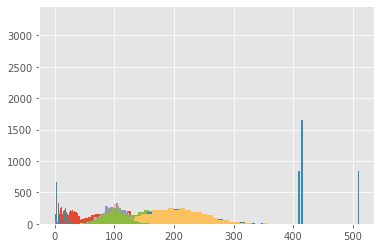

In [0]:
# Check normalization
for column in X.columns:
  print(column)
  analyze(X[column])
  print("\n")

In [0]:
X.columns

Index(['Account length', 'Area code', 'International plan', 'Voice mail plan',
       'Number vmail messages', 'Total day minutes', 'Total day calls',
       'Total day charge', 'Total eve minutes', 'Total eve calls',
       'Total eve charge', 'Total night minutes', 'Total night calls',
       'Total night charge', 'Total intl minutes', 'Total intl calls',
       'Total intl charge', 'Customer service calls', 'State_AK', 'State_AL',
       'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC',
       'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID',
       'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA',
       'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS',
       'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ',
       'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR',
       'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX',
       'S

mean :  0.024002400240024
var  :  0.0234262850227417
skew :  6.21989490937561
kurt :  36.68709268367661
shapiro :  (0.13613629341125488, 0.0)
normaltest :  NormaltestResult(statistic=3808.6077085908983, pvalue=0.0)


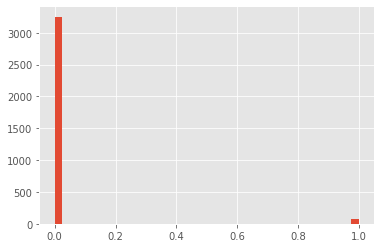

In [0]:
analyze(X['State_AL'])

In [0]:
columns_to_normalize = ['Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Customer service calls', 'State_AK', 'State_AL',
       'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC',
       'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID',
       'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA',
       'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS',
       'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ',
       'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR',
       'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX',
       'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV',
       'State_WY']

In [0]:
yeo_johnson_transform = PowerTransformer(method = 'yeo-johnson', standardize = True) # works with positive and negative values

In [0]:
for column in columns_to_normalize:
  X[column] = yeo_johnson_transform.fit_transform(X[column].values.reshape(X.shape[0], -1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Account length
mean :  101.06480648064806
var  :  1585.3243329733511
skew :  0.09656281161489656
kurt :  -0.10947391843415755
shapiro :  (0.9982772469520569, 0.0011495520593598485)
normaltest :  NormaltestResult(statistic=6.884425983113964, pvalue=0.03199380490776563)


Area code
mean :  0.0
var  :  0.0
skew :  0.0
kurt :  -3.0
shapiro :  (1.0, 1.0)
normaltest :  NormaltestResult(statistic=8487.391875205463, pvalue=0.0)


International plan
mean :  -1.0219514670116952e-16
var  :  1.0000000000000773
skew :  2.725104478550516
kurt :  5.426194419016079
shapiro :  (0.3360595703125, 0.0)
normaltest :  NormaltestResult(statistic=1772.7200918619708, pvalue=0.0)


Voice mail plan
mean :  5.709337726395194e-17
var  :  0.9999999999999624
skew :  0.9986898408240341
kurt :  -1.002618601834865
shapiro :  (0.5596232414245605, 0.0)
normaltest :  NormaltestResult(statistic=1155.3669896083206, pvalue=1.3039049077556625e-251)


Number vmail messages
mean :  -2.2557546722956974e-16
var  :  1.000000000000

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1657: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


mean :  179.77509750975116
var  :  2965.8063885668544
skew :  -0.029063979518119797
kurt :  -0.021710117924088834
shapiro :  (0.9995365738868713, 0.6374387741088867)
normaltest :  NormaltestResult(statistic=0.5096211575886979, pvalue=0.7750632974814358)


Total day calls
mean :  100.43564356435644
var  :  402.64729839320404
skew :  -0.11173632373075189
kurt :  0.24101722895174227
shapiro :  (0.9979861974716187, 0.0002773392479866743)
normaltest :  NormaltestResult(statistic=13.75152737998376, pvalue=0.0010325088208268448)


Total day charge
mean :  30.562307230723093
var  :  85.71140454767361
skew :  -0.02907017792703775
kurt :  -0.021581719145033595
shapiro :  (0.9995384216308594, 0.641385018825531)
normaltest :  NormaltestResult(statistic=0.5092159606353127, pvalue=0.7752203400325994)


Total eve minutes
mean :  200.98034803480346
var  :  2571.1223710759846
skew :  -0.023866708804637538
kurt :  0.0237916804447047
shapiro :  (0.9995718598365784, 0.711155354976654)
normaltest :  Normal

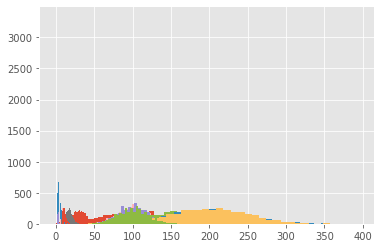

In [0]:
for column in X.columns:
  print(column)
  analyze(X[column])
  print("\n")

In [0]:
X.head()

NameError: ignored

### Standart Scaler

In [0]:
scaler = StandardScaler()

In [0]:
X_scaled = scaler.fit_transform(X)

In [0]:
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [0]:
X_scaled.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,0.68,-0.52,-0.33,1.62,1.23,1.57,0.48,1.57,-0.07,-0.06,-0.07,0.87,-0.47,0.87,-0.09,-0.60,-0.09,-0.43,-0.13,-0.16,-0.13,-0.14,-0.1,-0.14,-0.15,-0.13,-0.14,-0.14,-0.13,-0.13,-0.12,-0.15,-0.13,-0.15,6.83,-0.13,-0.12,-0.14,-0.15,-0.14,-0.15,-0.16,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.13,-0.14,-0.14,-0.14,-0.16,-0.15,-0.14,-0.15,-0.12,-0.14,-0.14,-0.14,-0.13,-0.15,-0.15,-0.15,-0.15,-0.14,-0.15,-0.18,-0.15
1,0.15,-0.52,-0.33,1.62,1.31,-0.33,1.12,-0.33,-0.11,0.14,-0.11,1.06,0.15,1.06,1.24,-0.60,1.24,-0.43,-0.13,-0.16,-0.13,-0.14,-0.1,-0.14,-0.15,-0.13,-0.14,-0.14,-0.13,-0.13,-0.12,-0.15,-0.13,-0.15,-0.15,-0.13,-0.12,-0.14,-0.15,-0.14,-0.15,-0.16,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.13,-0.14,-0.14,-0.14,-0.16,6.46,-0.14,-0.15,-0.12,-0.14,-0.14,-0.14,-0.13,-0.15,-0.15,-0.15,-0.15,-0.14,-0.15,-0.18,-0.15
2,0.90,-0.52,-0.33,-0.62,-0.59,1.17,0.68,1.17,-1.57,0.50,-1.57,-0.76,0.20,-0.76,0.70,0.21,0.70,-1.19,-0.13,-0.16,-0.13,-0.14,-0.1,-0.14,-0.15,-0.13,-0.14,-0.14,-0.13,-0.13,-0.12,-0.15,-0.13,-0.15,-0.15,-0.13,-0.12,-0.14,-0.15,-0.14,-0.15,-0.16,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.13,6.93,-0.14,-0.14,-0.16,-0.15,-0.14,-0.15,-0.12,-0.14,-0.14,-0.14,-0.13,-0.15,-0.15,-0.15,-0.15,-0.14,-0.15,-0.18,-0.15
3,-0.43,-0.69,3.05,-0.62,-0.59,2.20,-1.47,2.20,-2.74,-0.61,-2.74,-0.08,-0.57,-0.08,-1.30,1.02,-1.31,0.33,-0.13,-0.16,-0.13,-0.14,-0.1,-0.14,-0.15,-0.13,-0.14,-0.14,-0.13,-0.13,-0.12,-0.15,-0.13,-0.15,-0.15,-0.13,-0.12,-0.14,-0.15,-0.14,-0.15,-0.16,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.13,-0.14,-0.14,-0.14,-0.16,6.46,-0.14,-0.15,-0.12,-0.14,-0.14,-0.14,-0.13,-0.15,-0.15,-0.15,-0.15,-0.14,-0.15,-0.18,-0.15
4,-0.65,-0.52,3.05,-0.62,-0.59,-0.24,0.63,-0.24,-1.04,1.10,-1.04,-0.28,1.07,-0.28,-0.05,-0.60,-0.05,1.09,-0.13,-0.16,-0.13,-0.14,-0.1,-0.14,-0.15,-0.13,-0.14,-0.14,-0.13,-0.13,-0.12,-0.15,-0.13,-0.15,-0.15,-0.13,-0.12,-0.14,-0.15,-0.14,-0.15,-0.16,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.13,-0.14,-0.14,-0.14,-0.16,-0.15,7.32,-0.15,-0.12,-0.14,-0.14,-0.14,-0.13,-0.15,-0.15,-0.15,-0.15,-0.14,-0.15,-0.18,-0.15


Account length
mean :  1.7131344181359676e-16
var  :  0.9999999999999968
skew :  0.09656281161489608
kurt :  -0.10947391843415843
shapiro :  (0.9982772469520569, 0.0011495520593598485)
normaltest :  NormaltestResult(statistic=6.88442598311392, pvalue=0.03199380490776632)


Area code
mean :  1.1771761683244234e-16
var  :  0.9999999999999439
skew :  1.1263157243742072
kurt :  -0.706373725833584
shapiro :  (0.5902690291404724, 0.0)
normaltest :  NormaltestResult(statistic=651.8227674471639, pvalue=2.873984750354306e-142)


International plan
mean :  -1.0219514670116952e-16
var  :  1.0000000000000773
skew :  2.725104478550516
kurt :  5.426194419016079
shapiro :  (0.3360595703125, 0.0)
normaltest :  NormaltestResult(statistic=1772.7200918619708, pvalue=0.0)


Voice mail plan
mean :  6.921822517765003e-17
var  :  0.9999999999999624
skew :  0.9986898408240342
kurt :  -1.0026186018348648
shapiro :  (0.5596232414245605, 0.0)
normaltest :  NormaltestResult(statistic=1155.3669896083202, pvalue=1.

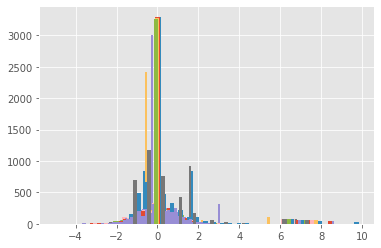

In [0]:
# Check normalization
for column in X_scaled.columns:
  print(column)
  analyze(X_scaled[column])
  print("\n")

## Training

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [0]:
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2666, 69) (2666,) (667, 69) (667,)


In [0]:
GaussianNB_param = {'var_smoothing':  [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 0.2, 0.5, 0.75, 0.9, 1.0]}
grid_search_fitting(GaussianNB(), GaussianNB_param, X_train, y_train, X_test, y_test)

accuracy
GaussianNB(priors=None, var_smoothing=0.01)
0.8743419381770192




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarnin

precision
GaussianNB(priors=None, var_smoothing=0.2)
0.82


recall
GaussianNB(priors=None, var_smoothing=1e-09)
0.6384483937115515


accuracy_on_test:  0.5547226386806596




GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid=False,
             n_jobs=None,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001, 0.001, 0.01, 0.1, 0.2, 0.5,
                                           0.75, 0.9, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [0]:
BernoulliNB_param = {'alpha': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 0.2, 0.5, 0.75, 0.9, 1.0], 
                     'binarize': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 0.2, 0.5, 0.75, 0.9, 1.0],
                     'fit_prior': ['True', 'False']}
grid_search_fitting(BernoulliNB(), BernoulliNB_param, X_train, y_train, X_test, y_test)

accuracy
BernoulliNB(alpha=0.5, binarize=1e-09, class_prior=None, fit_prior='True')
0.8585841593464447


precision
BernoulliNB(alpha=0.5, binarize=1e-09, class_prior=None, fit_prior='True')
0.5358771929824562


recall
BernoulliNB(alpha=1e-09, binarize=1e-09, class_prior=None, fit_prior='True')
0.11250854408749145


accuracy_on_test:  0.848575712143928




GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                                   fit_prior=True),
             iid=False, n_jobs=None,
             param_grid={'alpha': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 0.9, 1.0],
                         'binarize': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                      0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 0.9,
                                      1.0],
                         'fit_prior': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [0]:
KNeighborsClassifier_param = {'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                              'n_neighbors': [k for k in range (1, 11)],
                              'p': [p for p in range (1, 11, 2)]
                             }
grid_search_fitting(KNeighborsClassifier(), KNeighborsClassifier_param, X_train, y_train, X_test, y_test)

accuracy
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=7,
                     weights='uniform')
0.8743454542505471


precision
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=7,
                     weights='uniform')
0.773015873015873


recall
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=1,
                     weights='uniform')
0.2983595352016405


accuracy_on_test:  0.800599700149925




GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=False, n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 3, 5, 7, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [0]:
SVM_param = {'C': [0.1, 1, 10]}
grid_search_fitting(svm.SVC(), SVM_param, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

accuracy
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
0.8567150215272988




/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted 

precision
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
0.0




/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

recall
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
0.0


accuracy_on_test:  0.848575712143928




GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=None, param_grid={'C': [0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)